# Free Spoken Digits Data Loader

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import numpy as np
import librosa
from pathlib import Path
from librosa_transforms import MFCC, MelSpectrogram, LogPowerSpectrogram, PadTrim, toPILtoTensor
import sklearn
from FSSDData import FSDDDataFromDir, create_partition_from_dir
import torch
from torch.autograd import Variable
from torchvision.transforms import Compose, Grayscale, ToTensor, ToPILImage, Resize, Normalize
from torchvision.utils import make_grid
from torch.utils import data
from torch.backends import cudnn
import librosa.display
from PIL import Image

import torch.nn as nn
import torch.nn.functional as F

## Create data partition

In [5]:
# create_partition??

In [10]:
# FSDDDataFromDir??

In [2]:
DATA_DIR = Path('/home/workfit/Sylvain/Data/free-spoken-digit-dataset/recordings')
print(DATA_DIR / '*.wav')

/home/workfit/Sylvain/Data/free-spoken-digit-dataset/recordings/*.wav


In [3]:
partition, labels, wav_scp = create_partition_from_dir(DATA_DIR)

number of utterances:  1500


In [4]:
print(partition['validation'][:5])

['9_jackson_42', '0_jackson_22', '3_theo_45', '5_theo_45', '0_nicolas_6']


### maximum sample duration

In [44]:
%%bash
max_duration=0.0
for i in /home/workfit/Sylvain/Data/free-spoken-digit-dataset/recordings/*.wav; do
    duration=$(soxi -D $i);
    if (( $(echo $duration ">" $max_duration |bc -l) )); then
        max_duration=$duration
    fi    
done
echo $max_duration

2.282750


In [5]:
MAX_DURATION = 2.282750

## Create Torch Dataset & Dataloader

In [171]:
PARAMS= {
    'batch_size': 9,
    'shuffle': True,
    'num_workers': 5
    }


In [208]:
sr = 22050
max_duration_sample = int(MAX_DURATION * sr)
tsfm = Compose([PadTrim(max_duration_sample),
                MelSpectrogram(sr),
                toPILtoTensor()
               ])

tsfm2 = Compose([PadTrim(max_duration_sample),
                MelSpectrogram(sr),
                toPILtoTensor(),
                ToPILImage(),
                Resize((32,32)), ToTensor()])

In [209]:
training_ds = FSDDDataFromDir(partition['train'], labels, wav_scp, transform=tsfm)
training_dl = data.DataLoader(training_ds, **PARAMS)

validation_ds = FSDDDataFromDir(partition['validation'], labels, wav_scp, transform=tsfm)
validation_dl = data.DataLoader(validation_ds, **PARAMS)

In [210]:
validation_ds[0]

{'X': tensor([[[  0.0133,   0.0034,   0.0001,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0135,   0.0043,   0.0009,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0142,   0.2502,   0.7168,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]]]),
 'y': 'nine'}

In [217]:
toto = validation_ds[0]['X']
tf = Compose([ToPILImage(), Rescale(128), ToTensor()])
tf(toto)

NameError: name 'Rescale' is not defined

In [101]:
validation_ds[0]['X'].shape

torch.Size([1, 128, 99])

In [102]:
len(validation_dl.dataset.utt_ids)

300

In [103]:
dataiter = iter(validation_dl)
test_batch = dataiter.next()
#del dataiter
print(test_batch['X'].shape)
print(test_batch['y'])


torch.Size([9, 1, 128, 99])
['zero', 'five', 'six', 'six', 'three', 'nine', 'two', 'three', 'two']


In [105]:
# im = Image.fromarray(validation_ds[0]['X'].numpy())
# print(im.format, im.size, im.mode)
# plt.imshow(np.asarray(im))

## Plot data grid

In [42]:
batch_random = torch.randn((9, 1, 128, 99))
batch_random.shape

torch.Size([9, 1, 128, 99])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 392, 305])
(3, 392, 305)


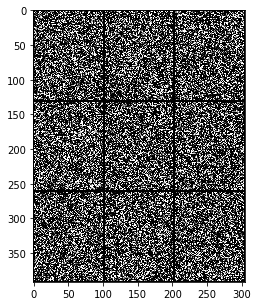

In [137]:
grid = make_grid(batch_random, nrow=3)
fig, ax = plt.subplots(figsize=(5, 5))
print(grid.shape)
print(grid.numpy().shape)

ax.imshow(np.transpose(grid.numpy(),(1,2,0)))
plt.savefig('test.png')
#librosa.display.specshow(grid.numpy(), sr=sr, x_axis='time')

In [107]:
test_batch['X'].shape

torch.Size([9, 1, 128, 99])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


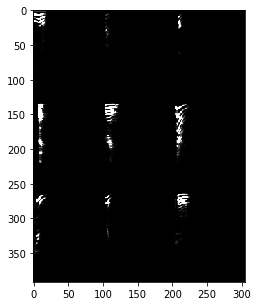

In [109]:
grid = make_grid(test_batch['X'], nrow=3)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(np.transpose(grid.numpy(),(1,2,0)))

## Check batch iter

In [127]:
print(test_batch['X'].shape)
print(test_batch['y'])

torch.Size([9, 1, 128, 99])
['zero', 'five', 'six', 'six', 'three', 'nine', 'two', 'three', 'two']


In [114]:
MAX_EPOCHS = 1
counter = 0
for i in range(MAX_EPOCHS):
    for batch in validation_dl:
        validation_batch, validation_label = Variable(batch['X']), batch['y']
        counter += 1
print(counter)

34


## Check cuda

In [112]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn.benchmark = True

## Model (CNN) 

In [175]:
params = {
    "learning_rate": 1e-3,
    "batch_size": 32,
    "num_epochs": 10,
    "dropout_rate":0.8, 
    "num_channels": 32,
    "save_summary_steps": 100,
    "num_workers": 4
}


In [189]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [184]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([10, 1, 5, 5])


In [193]:
# test output
input = test_batch['X'][0]
input = torch.randn(2, 1, 32, 32)
out = net(input)
print(out)
print(out.shape)

tensor([[-0.0735,  0.0889,  0.0684,  0.0994, -0.0209, -0.0172,  0.0002, -0.0105,
         -0.0990, -0.0596],
        [-0.0593,  0.1035,  0.0980,  0.1350, -0.0197,  0.0017,  0.0326,  0.0186,
         -0.0978, -0.0663]], grad_fn=<ThAddmmBackward>)
torch.Size([2, 10])


## Loss function

In [178]:
loss_fn = nn.CrossEntropyLoss()

## Optimizer

In [156]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training

In [179]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
epochs = 1

for epoch in range(epochs):
    model.train()
    
    train_losses = []
    valid_losses = []
    for i, sample in enumerate(validation_dl):
        optimizer.zero_grad()
        print(i, sample['X'].shape, sample['y'])
        
        outputs = model(sample['X'].double())
#         loss = loss_fn(outputs, sample['y'])
#         loss.backward()
#         optimizer.step()
        
#         train_losses.append(loss.item())
        
#         if (i * 128) % (128 * 100) == 0:
#             print(f'{i * 128} / 50000')
            
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for i, sample in enumerate(validation_loader):
#             outputs = model(sample['X'])
#             loss = loss_fn(outputs, sample['y'])
            
#             valid_losses.append(loss.item())
            
#             _, predicted = torch.max(outputs.data, 1)
#             correct += (predicted == labels).sum().item()
#             total += labels.size(0)
            
#     mean_train_losses.append(np.mean(train_losses))
#     mean_valid_losses.append(np.mean(valid_losses))
    
#     accuracy = 100 * correct / total
#     valid_acc_list.append(accuracy)

#     print('epoch : {}, train loss : {:.4f}, valid loss : {:.4f}, valid acc : {:.2f}%'\
#          .format(epoch+1, np.mean(train_losses), np.mean(valid_losses), accuracy))

0 torch.Size([9, 1, 128, 99]) ['three', 'eight', 'two', 'two', 'two', 'zero', 'eight', 'three', 'six']


RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #2 'weight'

## Metrics

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses, label='train')
ax1.plot(mean_valid_losses, label='valid')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')

ax2.plot(valid_acc_list, label='valid acc')
ax2.legend()

## Inference

In [ ]:
model.eval()
test_preds = torch.LongTensor()

for i, images in enumerate(test_loader):
    outputs = model(images)
    
    pred = outputs.max(1, keepdim=True)[1]
    test_preds = torch.cat((test_preds, pred), dim=0)


In [ ]:
out_df = pd.DataFrame()
out_df['ID'] = np.arange(1, len(X_test.index)+1)
out_df['label'] = test_preds.numpy()

out_df.head()
